In [1]:
%matplotlib notebook
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from context import *
from helpers.utils import load_perf_metrics, configure_plot_axes, load_adaptation_metrics
from helpers.constants import *

In [2]:
def read_loglike_results(base_direc, n_adapt, n_trials=50, index_col=1):
    methods = ['no_adaptation', 'transfer', 'transfer_last_layer', 'proposed', 'retrained_target']
    loglike = {m: [] for m in methods}
    fname = os.path.join(base_direc, 'results_{:d}'.format(n_adapt), 'loglike_comparison.csv')
    fp = open(fname, mode='r')
    cr = csv.reader(fp, delimiter=',')
    for i, row in enumerate(cr):
        if i == 0:
            continue

        loglike[row[0]].append(float(row[index_col]))

    fp.close()
    mean_loglike = dict()
    median_loglike = dict()
    CI_loglike = dict()
    for m in methods:
        vals = np.array(loglike[m])[:n_trials]
        if vals.shape[0] != n_trials:
            print("WARNING: method {} calculates using {} trials.".format(m, vals.shape[0]))
        
        mean_loglike[m] = np.mean(vals)
        p = np.percentile(vals, [2.5, 50, 97.5])
        median_loglike[m] = p[1]
        CI_loglike[m] = (p[0], p[2])
        
    return mean_loglike, median_loglike, CI_loglike

In [3]:
base_dir = '/Users/jr/Documents/research/code/domain_adaptation/expts_icml22/mdn_gmm_data_lambda_max_1'
methods = ['no_adaptation', 'transfer', 'transfer_last_layer', 'proposed', 'retrained_target']
n_adapt_list = np.array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

plots_dir = os.path.join(base_dir, 'plots')
if not os.path.isdir(plots_dir):
    os.makedirs(plots_dir)

In [4]:
n_sizes = n_adapt_list.shape[0]
mean_loglike = {m: np.zeros(n_sizes) for m in methods}
median_loglike = {m: np.zeros(n_sizes) for m in methods}
CI_loglike = {m: np.zeros((n_sizes, 2)) for m in methods}
for i, n_adapt in enumerate(n_adapt_list):
    means_, medians_, CI_ = read_loglike_results(base_dir, n_adapt)
    for m in methods:
        mean_loglike[m][i] = means_[m]
        median_loglike[m][i] = medians_[m]
        CI_loglike[m][i, 0] = CI_[m][0]
        CI_loglike[m][i, 1] = CI_[m][1]


In [5]:
legend_names = {
    'no_adaptation': 'No adapt',
    'transfer': 'Finetune',
    'transfer_last_layer': 'Finetune last',
    'proposed': 'Affine adapt (ours)',
    'retrained_target': 'Retrained MDN'
}

<IPython.core.display.Javascript object>


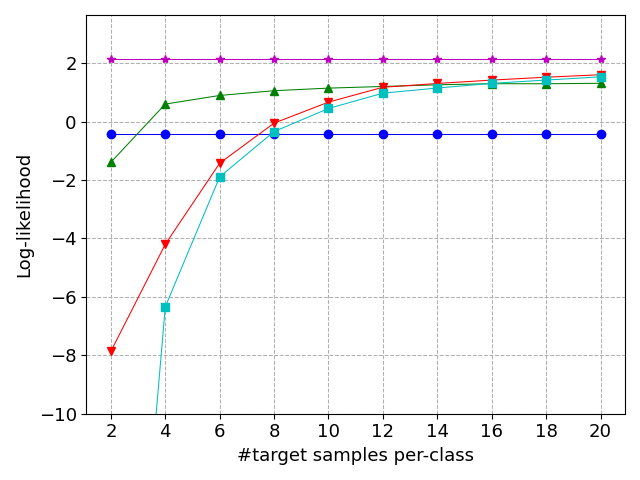

In [6]:
# Plot the log-likelihood vs number of target samples
fs = 13
fig = plt.figure()
y_vals = []
for i, m in enumerate(['no_adaptation', 'proposed', 'transfer', 'transfer_last_layer', 'retrained_target']):
    plt.plot(n_adapt_list, mean_loglike[m], linestyle='-', linewidth=0.75, color=COLORS[i], 
             marker=POINT_STYLES[i], label=legend_names[m])
    y_vals.extend(mean_loglike[m])

# plt.yscale('log')
# Increase the upper y-limit a bit
y_bot, y_top = plt.ylim()
plt.ylim((-10, 1.0 * y_top))

plt.xticks(n_adapt_list, fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel('#target samples per-class', fontsize=fs, fontweight='normal')
plt.ylabel('Log-likelihood', fontsize=fs, fontweight='normal')
plt.grid(True, axis='both', linestyle='dashed', linewidth=0.75, alpha=1.)
# plt.legend(loc='best', ncol=1, fontsize=10)
# plt.legend(loc='upper center', frameon=True, bbox_to_anchor=(0.5, 1.15), ncol=3, 
#            fontsize=10, fancybox=False)
# Save the figure
plot_filename = os.path.join(plots_dir, 'plot_loglike')
fig.tight_layout()
fig.savefig(plot_filename + '.png', dpi=600, bbox_inches='tight')
fig.savefig(plot_filename + '.pdf', dpi=600, bbox_inches='tight')
plt.show()